In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from network import ConvAutoEncoder
from models.pretrained.network import Network

In [2]:
# set available device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# extract and transform the data
train_set = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_set = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/glb/hou/pt.sgs/data/ml_ai_us/4d/csoftware/miniconda3/envs/deepwave/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# load the model we trained in the MNIST project; for the encoder part
pretrained_model = Network()
pretrained_model.load_state_dict(
    torch.load('models/pretrained/model-run(lr=0.001, batch_size=256).ckpt', map_location=device)
    )
model = ConvAutoEncoder(pretrained_model)
model

ConvAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nea

In [5]:
# to check if our weight transfer was successful or not
list(list(pretrained_model.layer2.children())[0].parameters()) == list(list(model.encoder.children())[4].parameters())
# or "False in (list(pretrained_model.layer1.children())[0].weight == list(model.encoder.children())[0].weight)" --> False

True

In [6]:
# freeze the transferred weights
for layer_num, child in enumerate(model.encoder.children()):
    if layer_num < 8:
        for param in child.parameters():
            param.requires_grad = False

In [7]:
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam([  # parameters which need optimization
                        {'params':model.encoder[8:].parameters()},
                        {'params':model.decoder.parameters()}
                        ], lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1/3, patience=3, verbose=True)

In [8]:
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = 0
    ###################
    # train the model #
    ###################
    loop = tqdm(train_loader, total=len(train_loader))
    for batch in loop:
        images = batch[0].to(device)
        _, outputs = model(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        loop.set_description(f'Epoch [{epoch+1:2d}/{num_epochs}]')
        loop.set_postfix(loss=train_loss)

    scheduler.step(train_loss)

  0%|          | 0/235 [00:00<?, ?it/s]/glb/hou/pt.sgs/data/ml_ai_us/4d/csoftware/miniconda3/envs/deepwave/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch [30/30]: 100%|██████████| 235/235 [00:06<00:00, 33.96it/s, loss=233]


In [9]:
# save the model
torch.save(model.state_dict(), 'models/model-autoencoder.pth')

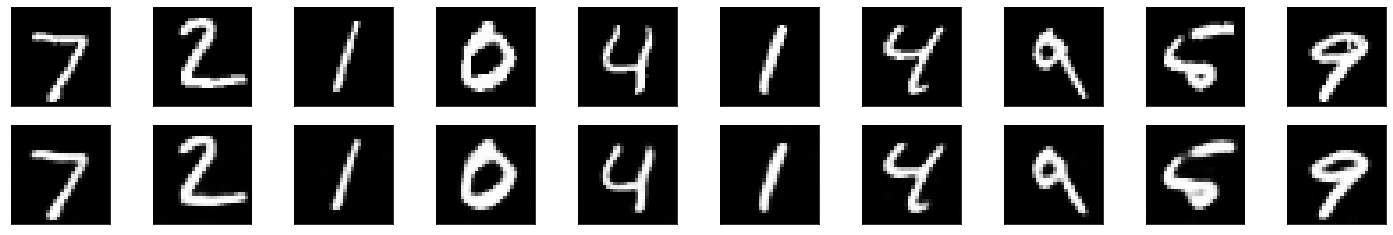

In [10]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
images = images.to(device)

# get sample outputs
encoded_imgs, decoded_imgs = model(images)
# prep images for display
images = images.cpu().numpy()

# use detach when it's an output that requires_grad
encoded_imgs = encoded_imgs.detach().cpu().numpy()
decoded_imgs = decoded_imgs.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, decoded_imgs], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()
fig.savefig('images/original_decoded.png', bbox_inches='tight')
plt.close()

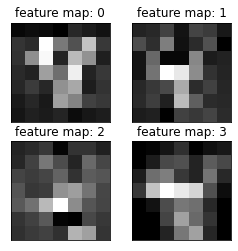

In [11]:
# plot the encoded image's feature maps
encoded_img = encoded_imgs[6]  # get the 7th image from the batch (7th image in the plot above)

fig = plt.figure(figsize=(4,4))
for fm in range(encoded_img.shape[0]):
    ax = fig.add_subplot(2, 2, fm+1, xticks=[], yticks=[])
    ax.set_title(f'feature map: {fm}')
    ax.imshow(encoded_img[fm], cmap='gray')

plt.show()
fig.savefig('images/encoded_img_4')
plt.close()

In [13]:
np.shape(encoded_img)

(4, 7, 7)

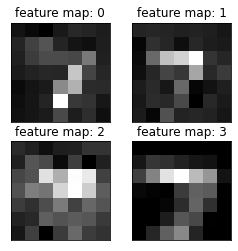

In [12]:
# again, cause why not?
encoded_img = encoded_imgs[0]  # get 1st image from the batch (here '7')

fig = plt.figure(figsize=(4,4))
for fm in range(encoded_img.shape[0]):
    ax = fig.add_subplot(2, 2, fm+1, xticks=[], yticks=[])
    ax.set_title(f'feature map: {fm}')
    ax.imshow(encoded_img[fm], cmap='gray')

plt.show()
fig.savefig('images/encoded_img_7')
plt.close()

In [ ]:
for batch in train_loader:
    